## Load splits.json into a dictionary

In [91]:
import json
import math
from pathlib import Path

import cv2
import numpy as np
import pandas as pd

from skimage.feature import graycomatrix, graycoprops
from skimage.filters import gabor

### Load & inspect splits.json

In [92]:
# Path to splits.json
SPLITS_FILE = Path('splits.json')

# Base directory that contains "geo fossil I"
# (so BASE_DIR / "geo fossil I\\Corals\\Coral172.jpg" exists)
BASE_DIR = SPLITS_FILE.parent

print("SPLITS_FILE:", SPLITS_FILE)
print("BASE_DIR:", BASE_DIR)
print("Exists?", SPLITS_FILE.exists(), BASE_DIR.exists())
with open(SPLITS_FILE, "r") as f:
    splits = json.load(f)

print("Keys in splits:", list(splits.keys()))
for k in splits:
    print(k, ":", len(splits[k]), "images")
    for i in range(len(splits[k])):
        splits[k][i] = splits[k][i].replace("\\", "/")

print("\nExample paths from 'train':")
print(splits["train"][:5])

SPLITS_FILE: splits.json
BASE_DIR: .
Exists? True True
Keys in splits: ['train', 'val', 'test']
train : 839 images
val : 180 images
test : 181 images

Example paths from 'train':
['geo fossil I/Corals/Coral172.jpg', 'geo fossil I/Ammonites/Ammonite104.jpg', 'geo fossil I/Belemnites/Belemnite113.jpg', 'geo fossil I/Crinoids/Crinoid137.jpg', 'geo fossil I/Corals/Coral16.jpg']


### Basic image + mask helpers

In [93]:
def load_gray_image(path: Path):
    """
    Load an image as 8-bit grayscale (0–255).
    """
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    return img  # uint8, shape (H, W)


def make_mask(gray: np.ndarray, min_area: int = 200):
    """
    Simple fossil mask using Otsu threshold + basic morphology.
    Returns uint8 mask with values {0,1}.
    """
    # Otsu threshold
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Two candidates: foreground white vs foreground black
    mask_white = (thresh == 255)
    mask_black = (thresh == 0)

    # Fossil usually occupies smaller area than background -> pick smaller
    if mask_white.sum() < mask_black.sum():
        mask = mask_white
    else:
        mask = mask_black

    # Convert to uint8
    mask = mask.astype(np.uint8)

    # Morphological opening + closing to clean edges
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Remove tiny blobs
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if num_labels > 1:
        # stats[0] is background; keep components >= min_area
        kept = np.zeros_like(mask)
        for i in range(1, num_labels):
            if stats[i, cv2.CC_STAT_AREA] >= min_area:
                kept[labels == i] = 1
        if kept.sum() > 0:
            mask = kept

    if mask.sum() == 0:
        # Fallback: full image
        mask = np.ones_like(mask, dtype=np.uint8)

    return mask


In [94]:
test_rel = splits["train"][0]
test_path = BASE_DIR / test_rel
gray_test = load_gray_image(test_path)
mask_test = make_mask(gray_test)

gray_test.shape, mask_test.shape, gray_test.dtype, mask_test.dtype, mask_test.sum()


((512, 512), (512, 512), dtype('uint8'), dtype('uint8'), 74276)

### Feature names (so CSV columns are interpretable)

In [95]:
# 1) Edge features (20)
EDGE_FEATURE_NAMES = (
    ["edge_density", "edge_mean_length"] +
    [f"edge_orient_bin_{i:02d}" for i in range(18)]
)

# 2) GLCM features (4 props × 2 distances × 4 angles = 32)
_GLCM_PROPS = ("contrast", "homogeneity", "energy", "correlation")
_GLCM_DISTANCES = [1, 2]
_GLCM_ANGLES = [0, 1, 2, 3]  # just indices; actual radians not needed for names

GLCM_FEATURE_NAMES = [
    f"glcm_{p}_d{d}_a{ai}"
    for p in _GLCM_PROPS
    for d in _GLCM_DISTANCES
    for ai in _GLCM_ANGLES
]


# 3) FFT radial (16)
FFT_FEATURE_NAMES = [f"fft_radial_band_{i:02d}" for i in range(16)]

# 4) Gabor (5 orientations × 4 wavelengths = 20)
GABOR_FEATURE_NAMES = [
    f"gabor_theta{ti}_wl{wl}"
    for ti in range(5)          # orientation index
    for wl in (2, 4, 8, 16)     # wavelength
]

# 5) Spiral curvature (4)
SPIRAL_FEATURE_NAMES = ["curv_mean", "curv_std", "curv_p95", "curv_pitch_ratio"]

# 6) Shape (3)
SHAPE_FEATURE_NAMES = ["shape_area", "shape_perimeter", "shape_roundness"]

FEATURE_NAMES = (
    EDGE_FEATURE_NAMES
    + GLCM_FEATURE_NAMES
    + FFT_FEATURE_NAMES
    + GABOR_FEATURE_NAMES
    + SPIRAL_FEATURE_NAMES
    + SHAPE_FEATURE_NAMES
)

print("Total features:", len(FEATURE_NAMES))
assert len(FEATURE_NAMES) == 95


Total features: 95


### 95-D texture feature functions

In [96]:
def edge_features(gray, mask):
    """
    20 dims: [density, mean_length, 18-bin orientation histogram]
    gray: uint8 (0-255), 2D
    mask: uint8 {0,1}
    """
    edges = cv2.Canny(gray, 100, 200) * mask
    coords = np.column_stack(np.nonzero(edges))
    if len(coords) == 0:
        return np.zeros(20, dtype=np.float32)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    angles = (np.arctan2(sobely, sobelx) + np.pi) * (180.0 / np.pi)
    ang_masked = angles[edges > 0]

    hist, _ = np.histogram(ang_masked, bins=18, range=(0, 180))
    edge_density = edges.sum() / mask.size
    mean_length = len(coords) / (np.count_nonzero(hist) + 1e-6)

    return np.concatenate(([edge_density, mean_length],
                           hist.astype(np.float32)))


def glcm_features(gray, mask):
    """
    32 dims: 4 props × 2 distances × 4 angles.
    """
    masked = gray.copy()
    masked[mask == 0] = 0

    levels = 32
    quant = (masked.astype(np.float32) / (256.0 / levels)).astype(np.uint8)
    distances = [1, 2]
    angles = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]

    glcm = graycomatrix(
        quant,
        distances=distances,
        angles=angles,
        levels=levels,
        symmetric=True,
        normed=True,
    )

    feats = []
    for prop in ("contrast", "homogeneity", "energy", "correlation"):
        vals = graycoprops(glcm, prop).flatten()
        feats.append(vals)

    return np.concatenate(feats).astype(np.float32)


# def lbp_features(gray, mask):
#     """
#     59-dim uniform LBP histogram.
#     """
#     lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
#     lbp_masked = lbp[mask > 0]
#     hist, _ = np.histogram(
#         lbp_masked,
#         bins=np.arange(0, 60),
#         range=(0, 59),
#         density=True,
#     )
#     return hist.astype(np.float32)


def fft_radial_energy(gray, mask, bands: int = 16):
    """
    16-dim normalized radial energy of FFT.
    """
    f = np.fft.fft2(gray * mask)
    fshift = np.fft.fftshift(f)
    magnitude = np.abs(fshift)

    h, w = magnitude.shape
    y, x = np.indices((h, w))
    center = np.array([(h - 1) / 2.0, (w - 1) / 2.0])
    r = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)
    r_norm = r / r.max()

    hist, _ = np.histogram(
        r_norm,
        bins=bands,
        range=(0.0, 1.0),
        weights=magnitude,
    )
    hist = hist / (hist.sum() + 1e-8)
    return hist.astype(np.float32)


def gabor_features(gray, mask):
    """
    20 dims: mean magnitude of Gabor responses.
    """
    orientations = np.linspace(0, np.pi, 5, endpoint=False)
    wavelengths = [2, 4, 8, 16]
    feats = []
    masked_gray = gray * (mask > 0)

    for theta in orientations:
        for wl in wavelengths:
            real, imag = gabor(masked_gray, frequency=1.0 / wl, theta=theta)
            mag = np.sqrt(real**2 + imag**2)
            vals = mag[mask > 0] if mask.sum() > 0 else mag.ravel()
            resp = vals.mean()
            feats.append(resp)

    return np.array(feats, dtype=np.float32)


def spiral_curvature(mask):
    """
    4 dims: mean, std, 95th percentile of curvature, and ellipse axis ratio.
    """
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return np.zeros(4, dtype=np.float32)

    cnt = max(contours, key=cv2.contourArea)
    if len(cnt) < 5:
        return np.zeros(4, dtype=np.float32)

    pts = cnt[:, 0, :].astype(np.float32)
    dx = np.gradient(pts[:, 0])
    dy = np.gradient(pts[:, 1])
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    curvature = np.abs(dx * ddy - dy * ddx) / (np.power(dx**2 + dy**2, 1.5) + 1e-6)

    curv_valid = curvature[np.isfinite(curvature)]
    if len(curv_valid) == 0:
        return np.zeros(4, dtype=np.float32)

    mean_c = curv_valid.mean()
    std_c = curv_valid.std()
    p95_c = np.percentile(curv_valid, 95)

    axes = (1.0, 1.0)
    if len(cnt) >= 5:
        ellipse = cv2.fitEllipse(cnt)
        axes = ellipse[1]  # (major, minor) axis lengths

    major = max(axes)
    minor = min(axes) + 1e-6
    pitch_ratio = major / minor

    return np.array([mean_c, std_c, p95_c, pitch_ratio], dtype=np.float32)


def shape_features(mask):
    """
    3 dims: area, perimeter, roundness.
    """
    area = float(mask.sum())
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        perimeter = float(cv2.arcLength(contours[0], True))
    else:
        perimeter = 0.0

    if perimeter > 0:
        roundness = 4 * math.pi * area / (perimeter**2 + 1e-6)
    else:
        roundness = 0.0

    return np.array([area, perimeter, roundness], dtype=np.float32)


### Wrapper: compute the full 95-D vector

In [97]:
def downscale_for_texture(gray, mask, size=224):
    """
    Downscale gray + mask to (size, size) for expensive texture features.
    gray: uint8 image (H, W)
    mask: uint8 {0,1} mask (H, W)
    """
    h, w = gray.shape[:2]

    # If already small, don't upscale
    if max(h, w) <= size:
        return gray, mask

    # Resize to square (size x size) with appropriate interpolation
    small_gray = cv2.resize(gray, (size, size), interpolation=cv2.INTER_AREA)
    small_mask = cv2.resize(mask, (size, size), interpolation=cv2.INTER_NEAREST)
    small_mask = (small_mask > 0).astype(np.uint8)

    return small_gray, small_mask

def compute_texture_features(gray, mask):
    """
    Returns a 95-D feature vector (np.float32) WITHOUT LBP.
    gray: uint8 grayscale image
    mask: uint8 {0,1}
    """
    mask = (mask > 0).astype(np.uint8)
    if mask.sum() == 0:
        return np.zeros(95, dtype=np.float32)

    # --- 1) Features on full resolution (e.g., 512x512) ---
    edge_vec   = edge_features(gray, mask)      # 20
    spiral_vec = spiral_curvature(mask)         # 4
    shape_vec  = shape_features(mask)           # 3

    # --- 2) Downscaled for heavy features (GLCM, FFT, Gabor) ---
    small_gray, small_mask = downscale_for_texture(gray, mask, size=224)

    glcm_vec  = glcm_features(small_gray, small_mask)        # 32
    fft_vec   = fft_radial_energy(small_gray, small_mask)    # 16
    gabor_vec = gabor_features(small_gray, small_mask)       # 20

    feats = np.concatenate([
        edge_vec,        # 20
        glcm_vec,        # 32
        fft_vec,         # 16
        gabor_vec,       # 20
        spiral_vec,      # 4
        shape_vec,       # 3
    ]).astype(np.float32)

    assert feats.shape[0] == 95
    return feats



In [98]:
#testing one image
vec_test = compute_texture_features(gray_test, mask_test)
len(vec_test), vec_test[:10]

(95,
 array([  23.202953, 1325.1666  ,  580.      ,  627.      ,  709.      ,
         685.      ,  628.      ,  555.      ,  441.      ,  363.      ],
       dtype=float32))

### Loop over ALL images and build a DataFrame

In [99]:
import time
from IPython.display import clear_output

all_rows = []

for split_name, rel_paths in splits.items():
    processed_in_split = 0
    n_files = len(rel_paths)
    print(f"\n=== Processing split: {split_name}, n={n_files} ===")

    for i, rel in enumerate(rel_paths, start=1):
        rel_path = Path(rel)        # "geo fossil I\\Corals\\Coral172.jpg"
        img_path = BASE_DIR / rel_path

        if not img_path.is_file():
            print("WARNING: file not found:", img_path)
            continue

        start_time = time.time()
        try:
            gray = load_gray_image(img_path)
            mask = make_mask(gray)
            feats = compute_texture_features(gray, mask)

            class_name = img_path.parent.name  # Ammonites / Corals / ...

            row = {
                "split": split_name,
                "class_name": class_name,
                "image_rel_path": str(rel_path),
            }
            for fname, fval in zip(FEATURE_NAMES, feats):
                row[fname] = float(fval)

            all_rows.append(row)
            processed_in_split += 1

            duration = time.time() - start_time

            print(f"=== Processing split: {split_name}, n={n_files} === Processed in this split: {processed_in_split}/{n_files} Time for last file: {duration:.3f} seconds")
            # print(f"Processed in this split: {processed_in_split}/{n_files}")
            # print(f"Last file: {img_path}")
            # print(f"Time for last file: {duration:.3f} seconds")

            # Update console every 20 images (and on the very last one)
            if (i % 20 == 0) or (i == n_files):
                clear_output(wait=True)
            
        except Exception as e:
            duration = time.time() - start_time
            print(f"Error processing {img_path} (after {duration:.3f}s): {e}")


=== Processing split: test, n=181 === Processed in this split: 181/181 Time for last file: 1.429 seconds


### Save to CSV and quick check

In [100]:
features_df = pd.DataFrame(all_rows)
print("DataFrame shape:", features_df.shape)
display(features_df.head())
out_csv = BASE_DIR / "geo_fossil_texture_features_95.csv"
features_df.to_csv(out_csv, index=False)
print("Saved CSV to:", out_csv)

DataFrame shape: (1200, 98)


,split,class_name,image_rel_path,edge_density,edge_mean_length,edge_orient_bin_00,edge_orient_bin_01,edge_orient_bin_02,edge_orient_bin_03,edge_orient_bin_04,...,gabor_theta4_wl4,gabor_theta4_wl8,gabor_theta4_wl16,curv_mean,curv_std,curv_p95,curv_pitch_ratio,shape_area,shape_perimeter,shape_roundness
0,train,Corals,geo fossil I/Corals/Coral172.jpg,23.202953,1325.166626,580.0,627.0,709.0,685.0,628.0,...,4.187500,3.511719,2.666016,0.253856,0.369395,0.715541,1.725064,74276.0,120.627419,64.145515
1,train,Ammonites,geo fossil I/Ammonites/Ammonite104.jpg,13.507576,771.444397,117.0,184.0,323.0,431.0,535.0,...,3.285156,3.160156,3.041016,0.259871,0.510326,0.715541,2.200247,101630.0,163.497467,47.775990
2,train,Belemnites,geo fossil I/Belemnites/Belemnite113.jpg,5.858860,334.611084,344.0,335.0,368.0,322.0,221.0,...,2.244141,2.035156,2.175781,0.212571,0.264686,0.707107,3.609439,46337.0,118.426407,41.518406
3,train,Crinoids,geo fossil I/Crinoids/Crinoid137.jpg,21.772041,1243.444336,403.0,717.0,1081.0,1291.0,1244.0,...,3.152344,2.539062,2.242188,0.213678,0.306754,0.715541,1.658530,101262.0,74.142136,231.486771
4,train,Corals,geo fossil I/Corals/Coral16.jpg,18.625202,1063.722168,205.0,303.0,438.0,535.0,574.0,...,3.335938,3.160156,2.898438,0.225900,0.332490,0.715541,1.304244,116701.0,505.646759,5.735747


Saved CSV to: geo_fossil_texture_features_95.csv


# Result analysis sections

In [101]:
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
features_df = pd.read_csv('geo_fossil_texture_features_95.csv')
RESULTS_DIR = Path("results/textual features")

### Mask quality visualization (original / mask / masked)

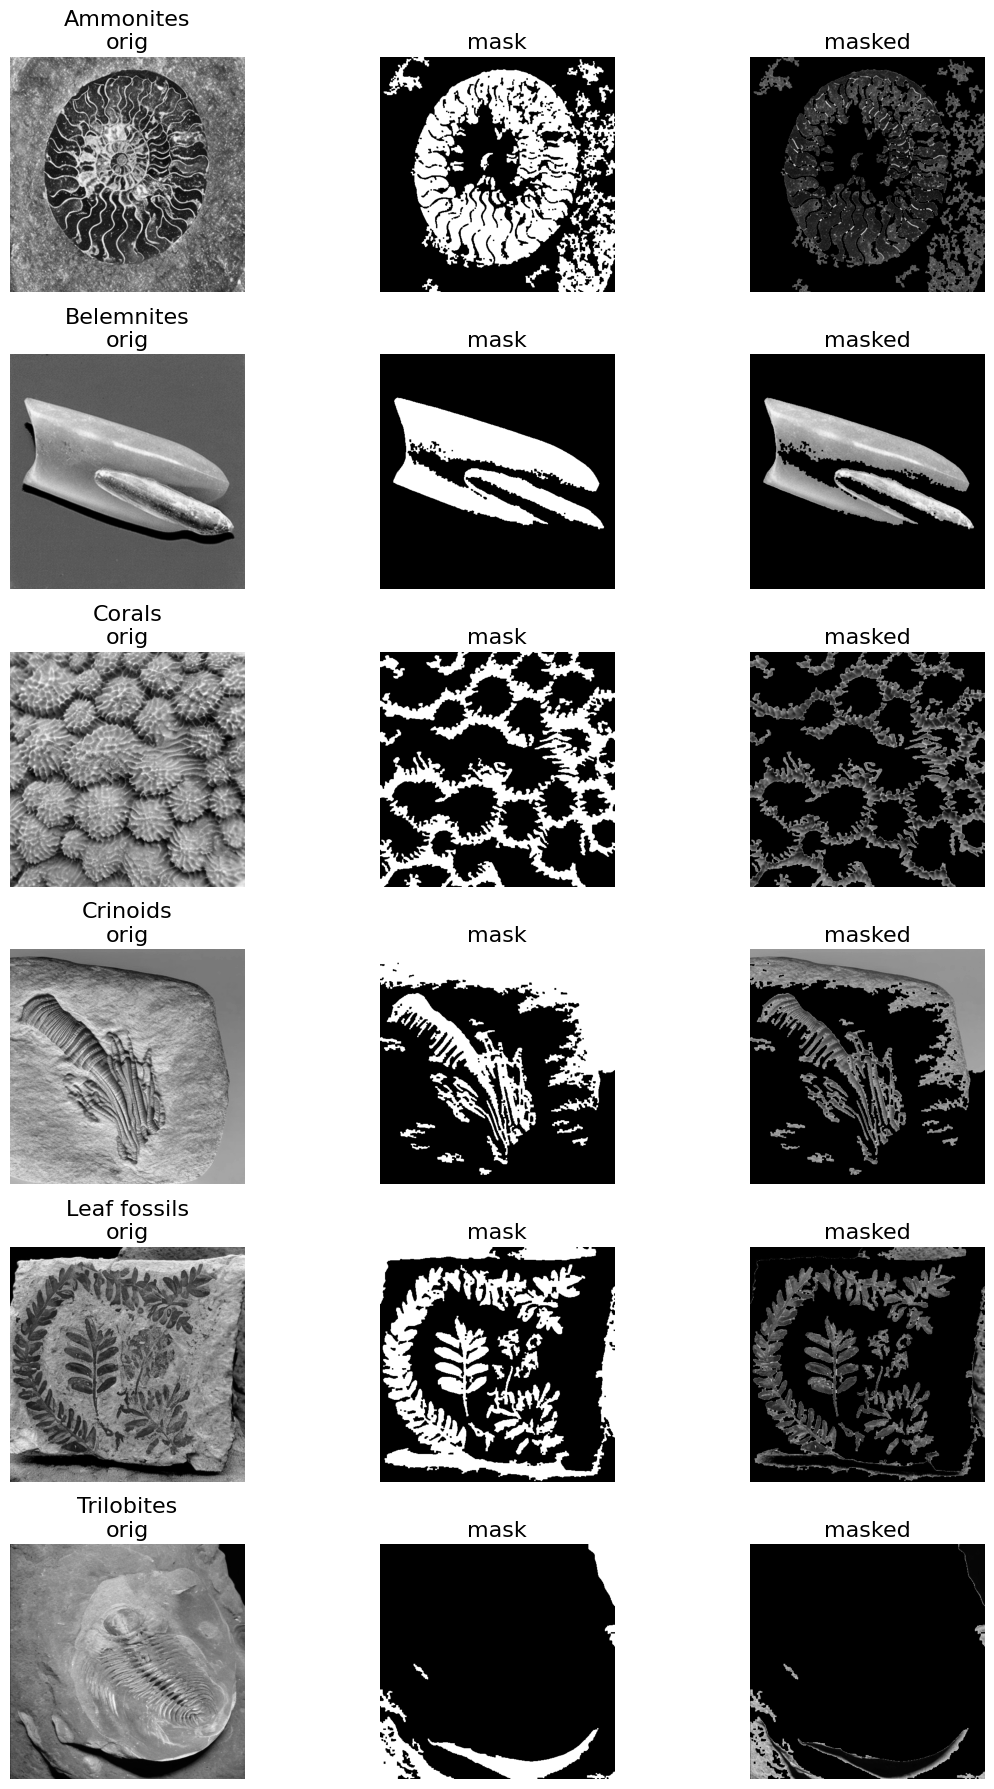

Saved figure to: results/textual features/mask quality.png


In [108]:
def show_mask_examples_per_class(split_name="train", images_per_class=1):
    """
    For each class, randomly sample 'images_per_class' images from 'split_name'
    and show original, mask, and masked image.
    """
    # Build mapping: class_name -> list of image Paths
    paths_by_class = {}
    for rel in splits[split_name]:
        img_path = BASE_DIR / rel
        cls = img_path.parent.name
        paths_by_class.setdefault(cls, []).append(img_path)

    classes = sorted(paths_by_class.keys())
    
    n_classes = len(classes)
    n_cols = 3 * images_per_class  # original, mask, masked per example
    fig, axes = plt.subplots(n_classes, n_cols, figsize=(4 * n_cols, 3 * n_classes))
    
    if n_classes == 1:
        axes = np.array([axes])  # ensure 2D
    
    for row, cls in enumerate(classes):
        # pick random images for this class
        candidates = paths_by_class[cls]
        random.shuffle(candidates)
        chosen = candidates[:images_per_class]
        
        for j, img_path in enumerate(chosen):
            gray = load_gray_image(img_path)
            mask = make_mask(gray)
            masked = gray * mask

            col0 = 3*j
            ax_orig  = axes[row, col0]
            ax_mask  = axes[row, col0 + 1]
            ax_mixed = axes[row, col0 + 2]

            ax_orig.imshow(gray, cmap="gray")
            ax_orig.set_title(f"{cls}\norig", fontsize=16)
            ax_orig.axis("off")

            ax_mask.imshow(mask, cmap="gray")
            ax_mask.set_title("mask", fontsize=16)
            ax_mask.axis("off")

            ax_mixed.imshow(masked, cmap="gray")
            ax_mixed.set_title("masked", fontsize=16)
            ax_mixed.axis("off")
    
    plt.tight_layout()
    
    out_path = RESULTS_DIR / "mask quality.png"  # change the file name
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    # plt.savefig('./results/textual features/mask quality.png')
    plt.show()
    print("Saved figure to:", out_path)
    

# Example: 1 example per class, from train split
show_mask_examples_per_class(split_name="train", images_per_class=1)


### Distribution of key features by class (boxplots)

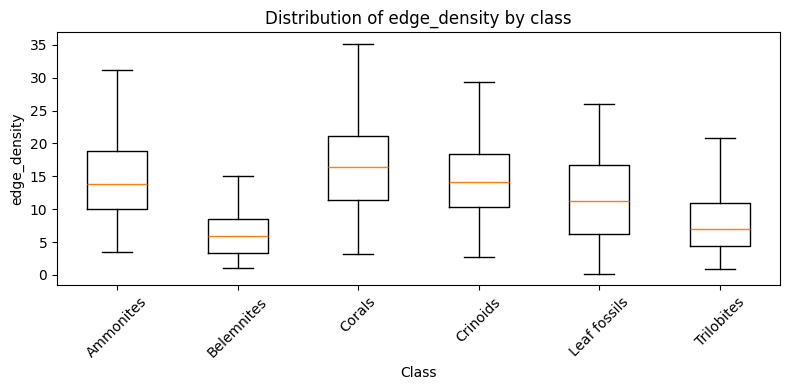

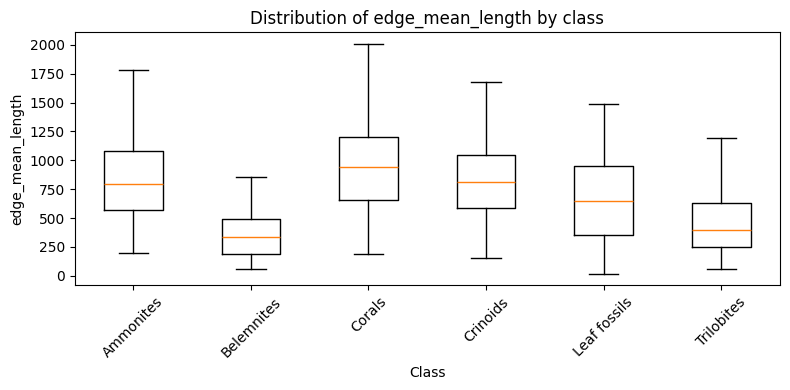

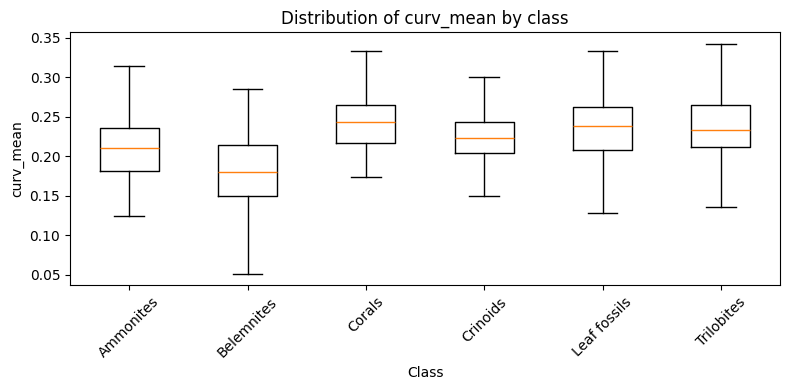

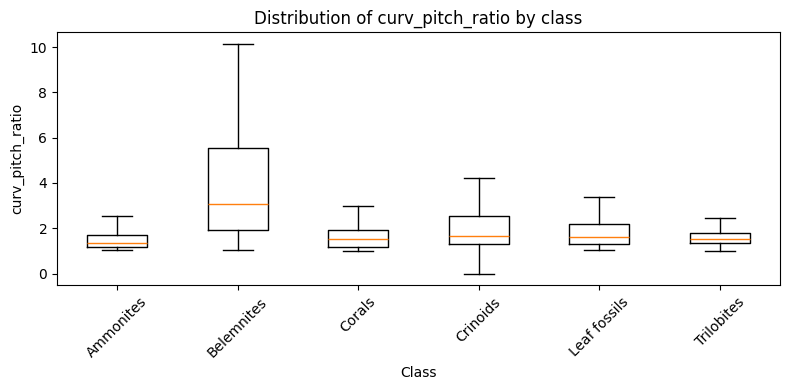

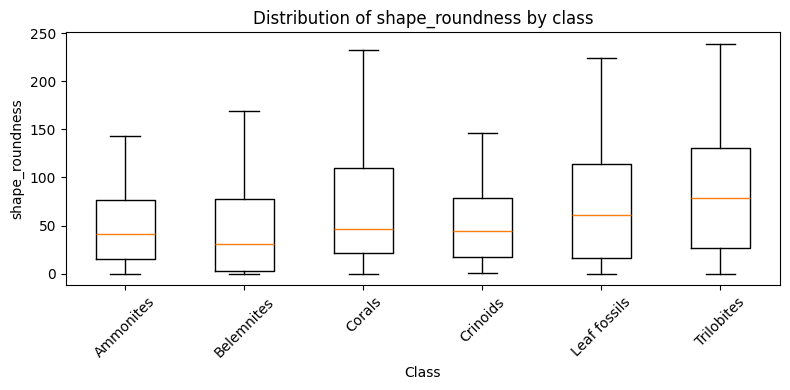

In [109]:
train_df = features_df[features_df["split"] == "train"].copy()
classes = sorted(train_df["class_name"].unique())

key_features = [
    "edge_density",
    "edge_mean_length",
    "curv_mean",
    "curv_pitch_ratio",
    "shape_roundness",
]

for feat in key_features:
    plt.figure(figsize=(8, 4))
    data = [train_df[train_df["class_name"] == cls][feat].values for cls in classes]
    plt.boxplot(data, labels=classes, showfliers=False)
    plt.title(f"Distribution of {feat} by class")
    plt.xlabel("Class")
    plt.ylabel(feat)
    plt.xticks(rotation=45)
    plt.tight_layout()
    out_path = RESULTS_DIR / "distribution of features(boxplot).png"  # change the file name
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()


### t-SNE embeddings of the 95-D features

In [110]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Use only train split for visualization (to avoid leakage)
vis_df = features_df[features_df["split"] == "train"].copy()
classes = sorted(vis_df["class_name"].unique())

# Feature columns = everything except meta
meta_cols = ["split", "class_name", "image_rel_path"]
feature_cols = [c for c in vis_df.columns if c not in meta_cols]

X = vis_df[feature_cols].values
y = vis_df["class_name"].values

print("X shape:", X.shape, "   #features:", len(feature_cols))


X shape: (839, 95)    #features: 95


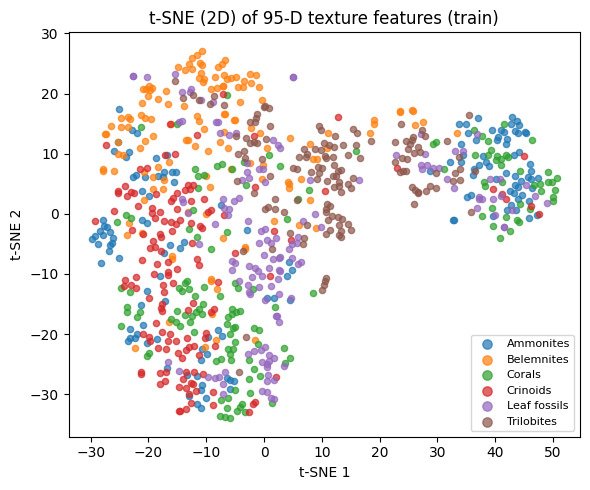

In [111]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42,
)
X_tsne = tsne.fit_transform(X_scaled)
plt.figure(figsize=(6, 5))

for cls in classes:
    idx = (y == cls)
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=cls, alpha=0.7, s=20)

plt.title("t-SNE (2D) of 95-D texture features (train)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(markerscale=1.5, fontsize=8)
plt.tight_layout()
out_path = RESULTS_DIR / "features t-sne.png"  # change the file name
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()


### Correlation heatmap of features

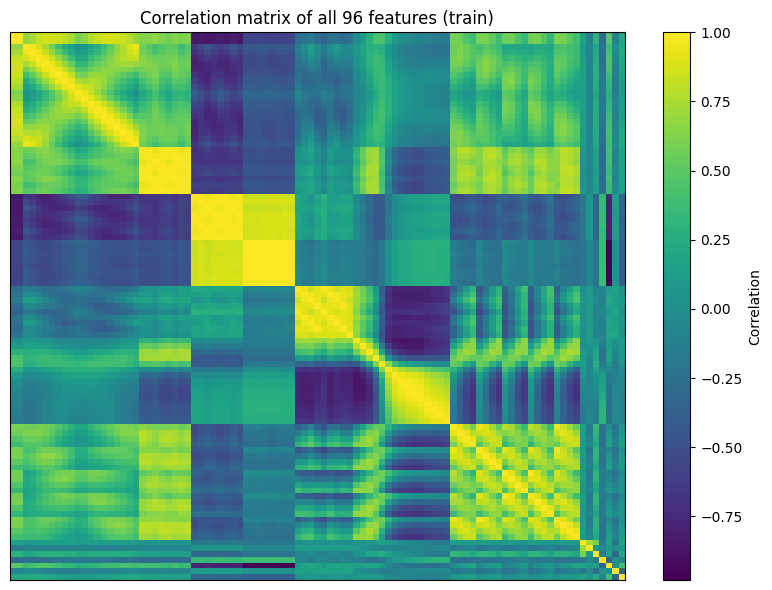

In [113]:
# Full correlation heatmap (coarse)
corr_full = vis_df[feature_cols].corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr_full.values, aspect="auto")
plt.colorbar(label="Correlation")
plt.title("Correlation matrix of all 96 features (train)")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

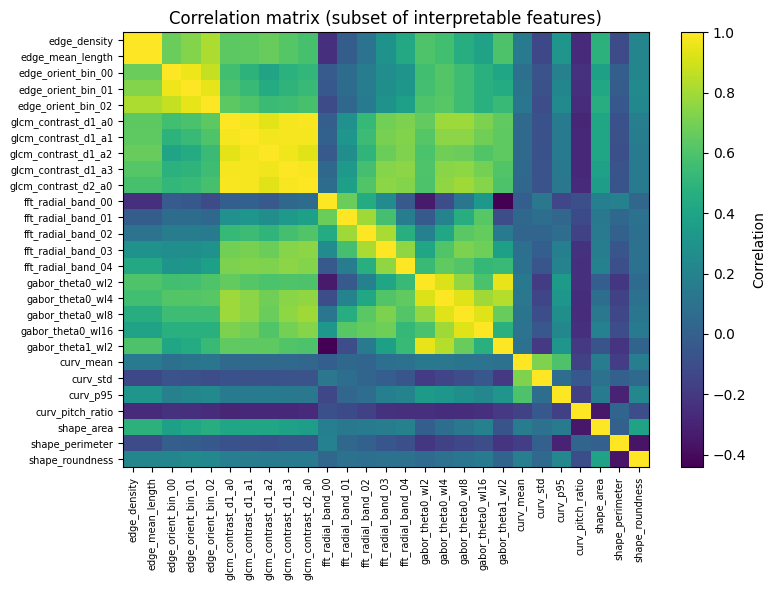

In [114]:
# Subset of features with labels
subset_feats = (
    EDGE_FEATURE_NAMES[:5]      # a few edge features
    + GLCM_FEATURE_NAMES[:5]    # a few GLCM
    + FFT_FEATURE_NAMES[:5]     # a few FFT
    + GABOR_FEATURE_NAMES[:5]   # a few Gabor
    + SPIRAL_FEATURE_NAMES      # all 4
    + SHAPE_FEATURE_NAMES       # all 3
)

subset_feats = [f for f in subset_feats if f in vis_df.columns]  # safety

corr_sub = vis_df[subset_feats].corr()

plt.figure(figsize=(8, 6))
im = plt.imshow(corr_sub.values, aspect="auto")
plt.colorbar(im, label="Correlation")

plt.xticks(range(len(subset_feats)), subset_feats, rotation=90, fontsize=7)
plt.yticks(range(len(subset_feats)), subset_feats, fontsize=7)

plt.title("Correlation matrix (subset of interpretable features)")
plt.tight_layout()
plt.show()
